## stock price prediction

#### evaluating diffrent models

we evaluate and visualize different models to determine the correlation (aka similarity) between their outputs, in order to create diverse strategies that will perform well when combined into one model.

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import make_scorer

#### creating features
* The spread feature measures volatility. 
* The gap feature measures the price movement after hours
* The intraday feature measures the price movement from the open to close.

In [72]:
def create_features(df):
    df['Spread'] = df['High'] - df['Low']
    df['Gap'] = df['Open'] - df['Close'].shift(1)
    df['Intraday'] = df['Open'] - df['Close']
    return df

#### calculating features
* to measure the percentage change and rolling average for Spread, Gap, and Intraday over the last n periods.
* lookback:maximum period over which we want to look back.
  step: interval at which we calculate the new features.


In [73]:
def process_features(df, lookback, step):
    for i in range(step, lookback+1, step):
        df['%d Spread' % (i)] = df['Spread'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Spread' % (i)] = df['Spread'].rolling(window=i).mean()

        df['%d Gap' % (i)] = df['Gap'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Gap' % (i)] = df['Gap'].rolling(window=i).mean()

        df['%d Intraday' % (i)] = df['Intraday'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Intraday' % (i)] = df['Intraday'].rolling(window=i).mean()
    return df

### dropping extra columns

In [74]:
def drop_features(df):
    df.drop(columns=['Spread','Gap','Intraday'],inplace=True)
    df.drop(columns=['Open','High','Low','Close','Volume','Adj Close'], inplace=True)
    return df

#### creating a target

* calculates the percentage change in price over these days and then takes the natural logarithm of that change.
* This can help predict future price movements based on past data.

In [75]:
def create_target(df, lookforward=2, target='Open'):
    df['Target'] = np.log(df[target].shift(periods=-lookforward)/df[target].shift(periods=-1))
    return df

#### developing models

* Ridge Regression: It smooths out our predictions by putting a limit on how much the factors can influence the outcome.* 
Lasso Regression: It helps us pick out the most important factors for prediction and ignores the less important ones
* KNeighborsRegressor:  A non-linear regression model that makes predictions based on the closest data points.

In [76]:
estimator1 = Ridge()
estimator2 = Lasso(alpha=.001)
estimator3 = KNeighborsRegressor()
models = [estimator1,estimator2,estimator3]

In [77]:
lookforward = 2
step = 21
lookback = 21
results = pd.DataFrame()

#### defining the models
* SPY (representing the S&P 500) reflects the stock market, while AGG (a bond market index) reflects the bond market. 
* Combining them provides insights from both markets, which can enhance the predictive power of the model.

In [78]:
for model in models:
    if lookback >= step:
        # importing data
        spy = yf.download('SPY', start='2004-01-01')
        agg = yf.download('AGG', start='2004-01-01')

        # creating target
        spy = create_target(spy, lookforward, target='Open')

        # adding features
        spy = create_features(spy)
        spy = process_features(spy, lookback, step)
        spy = spy.add_suffix(' SPY')

        agg = create_features(agg)
        agg = process_features(agg, lookback, step)
        agg = agg.add_suffix(' AGG')
        cv = pd.merge(spy, agg, how='inner', on='Date')

        # remove rows from end and begining to enusre enough data for lookback and forward 
        cv.drop(cv.tail(lookforward).index, inplace=True)
        cv.drop(cv.head(lookback).index, inplace=True)

        # filling null values
        X = cv
        y = X[['Target SPY']]
        X = X.drop(columns=['Target SPY'])
        X.fillna(method="ffill", inplace=True)
        X.replace([np.inf, -np.inf], 0, inplace=True)
        X.fillna(0, inplace=True)

        #training the model
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, shuffle=False)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[model] = y_pred.flatten()

    else:
        print('Lookback must be greater than or equal to step')
        break

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Vasudharajesh.i\AppData\Local\Temp\ipykernel_12900\1502594381.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
C:\Users\Vasudharajesh.i\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.42585e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Vasudharajesh.i\AppData\Local\Temp\ipykernel_12900\1502594381.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


#### visulaise correltation of models 

In [79]:
!pip install seaborn --upgrade -q

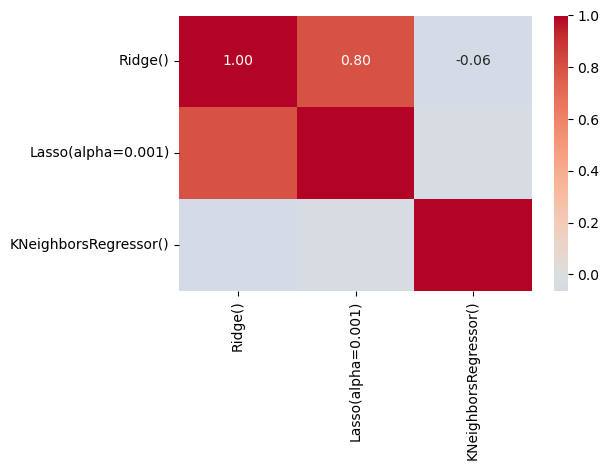

In [80]:
correlation = results.corr()
sns.heatmap(correlation, annot=True, fmt='.2f',cmap='coolwarm', center=0)
plt.tight_layout()
plt.show()

* Here we see the models are mostly uncorrelated, which is good.
* when we have uncorrelated models, each model has its own strategy to maximize the scoring function, and when we combine all these uncorrelated strategies, we get a meta-model which has a robust strategy.

### Finding optimal interval and lookback

#### create a scoring function

 we are scoring different models on their average returns,

In [81]:
def custom_score(y_true, y_pred):
  pred_sign = np.sign(y_pred)
  y_true = np.squeeze(y_true)
  returns = np.where((pred_sign == 1), y_true, 0)
  return returns.mean()

custom_scorer = make_scorer(custom_score, greater_is_better=True)

#### combining 3 models into 1 

We combine the 3 models into 1 using the VotingRegressor. The VotingRegressor works by averaging the output of the models that its composed of into a single output.

In [82]:
estimator1 = Ridge()
estimator2 = Lasso(alpha=.001)
estimator3 = KNeighborsRegressor()
models = [estimator1,estimator2,estimator3]
estimator = VotingRegressor(estimators=[('Ridge', estimator1),('Lasso', estimator2),('KNN', estimator3)])

#### Define target, cross validation folds, interval, and lookback parameters.
* we test the model 5 times (n_splits=5). We also have to add a gap between each split, otherwise there will be some overlap, which could cause the models to peek at data it shouldn't, and artificially inflate its score.
* Next we define the steps (or intervals) and lookbacks we want to test our model at, in order to find the ones that it scores the highest on.
* we create an object to store the results of our model in.

In [83]:
lookforward = 2
tscv = TimeSeriesSplit(n_splits=5, gap=lookforward)
steps = [1, 2, 3, 4, 5]
lookbacks = [1, 2, 3, 4, 5]
cv_results = pd.DataFrame(columns=['step', 'lookback', 'score'])

#### Evaluate and visualize scores of different combinations of parameters

In [84]:
for step in steps:
    for lookback in lookbacks:
        if lookback >= step:
            # importing data
            spy = yf.download('SPY', start='2004-01-01')
            agg = yf.download('AGG', start='2004-01-01')

            # creating target
            spy = create_target(spy, lookforward, target='Open')

            # adding features
            spy = create_features(spy)
            spy = process_features(spy, lookback, step)
            spy = spy.add_suffix(' SPY')

            agg = create_features(agg)
            agg = process_features(agg, lookback, step)
            agg = agg.add_suffix(' AGG')
            cv = pd.merge(spy, agg, how='inner', on='Date')

            # remove rows from end and begining to enusre enough data for lookback and forward 
            cv.drop(cv.tail(lookforward).index, inplace=True)
            cv.drop(cv.head(lookback).index, inplace=True)

            # filling null values
            X = cv
            y = X[['Target SPY']]
            X = X.drop(columns=['Target SPY'])
            X.fillna(method="ffill", inplace=True)
            X.replace([np.inf, -np.inf], 0, inplace=True)
            X.fillna(0, inplace=True)

            cv_score = cross_val_score(estimator=estimator, X=X, y=y,
                                       scoring=custom_scorer,
                                       cv=tscv, verbose=0)
            
            new_row = {'step': step, 'lookback': lookback, 'score': cv_score.mean()}
            cv_results = pd.concat([cv_results, pd.DataFrame([new_row])], ignore_index=True)

            

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\Vasudharajesh.i\AppData\Local\Temp\ipykernel_12900\2117599840.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method="ffill", inplace=True)
C:\Users\Vasudharajesh.i\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vasudharajesh.i\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.01017e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Vasudharajesh.i\AppData\Local\anaconda3\Lib\site-packa

#### visulaise heatmap

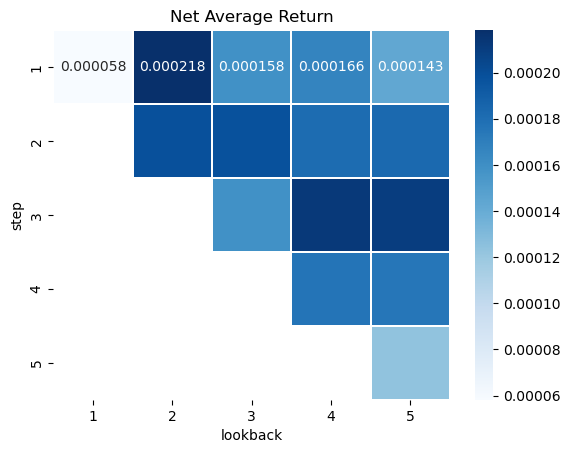

In [85]:
cv_results = cv_results.pivot(index='step', columns='lookback', values='score')
sns.heatmap(cv_results, annot=True, fmt='.6f', linewidths=.25, cmap='Blues')
plt.title('Net Average Return')
plt.show()

Here we can see a 1 period step interval with a maximum look back of 2 periods performs the best. In the next notebook, we will adjust the parameters of the models

In [86]:
!pip install backtesting -q
from backtesting import Strategy, Backtest

In [91]:
step = 1
lookback = 2

estimator1 = Ridge(alpha=0.002840026017965097)
estimator2 = Lasso(alpha=0.002999525583333498)
estimator3 = KNeighborsRegressor(n_neighbors=8)
models = [estimator1,
          estimator2,
          estimator3,]
estimator = VotingRegressor(estimators=[('Ridge', estimator1),
                                        ('Lasso', estimator2),
                                        ('KNN', estimator3)],)

X_test = X_test.iloc[(abs(lookforward)):]
y_test = y_test.iloc[(abs(lookforward)):]

estimator.fit(X_train, y_train)
forecasted = estimator.predict(X_test)

data = yf.download('SPY', start='2004-01-01')
data.drop(data.tail(lookforward).index,inplace=True)
data.drop(data.head(lookback).index,inplace=True)
data = data.iloc[(-X_test.shape[0]):]
data['forecastedValue'] = forecasted
prediction = data

C:\Users\Vasudharajesh.i\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vasudharajesh.i\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.31851e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
[*********************100%%**********************]  1 of 1 completed
C:\Users\Vasudharajesh.i\AppData\Local\Temp\ipykernel_12900\1794395914.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['forecastedVal

In [92]:
class MyStrategy(Strategy):
    Data = prediction

    def init(self):
        super().init()

    def next(self):
        if self.data.forecastedValue < 0:
            self.sell()
        elif self.data.forecastedValue > 0:
            self.buy()


bt = Backtest(prediction, MyStrategy,
              cash=1000,
              trade_on_close=False,
              exclusive_orders=True
              )
print(bt.run())

Start                     2009-03-16 00:00:00
End                       2024-06-11 00:00:00
Duration                   5566 days 00:00:00
Exposure Time [%]                   76.101121
Equity Final [$]                   340.110344
Equity Peak [$]                    1020.65023
Return [%]                         -65.988966
Buy & Hold Return [%]              607.817042
Return (Ann.) [%]                   -6.838061
Volatility (Ann.) [%]               11.638111
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -66.677091
Avg. Drawdown [%]                  -28.772887
Max. Drawdown Duration     4635 days 00:00:00
Avg. Drawdown Duration     1391 days 00:00:00
# Trades                                 2916
Win Rate [%]                         43.82716
Best Trade [%]                       8.799434
Worst Trade [%]                     -6.348897
Avg. Trade [%]                    